Predicted class index: 1
Layer index index: 1


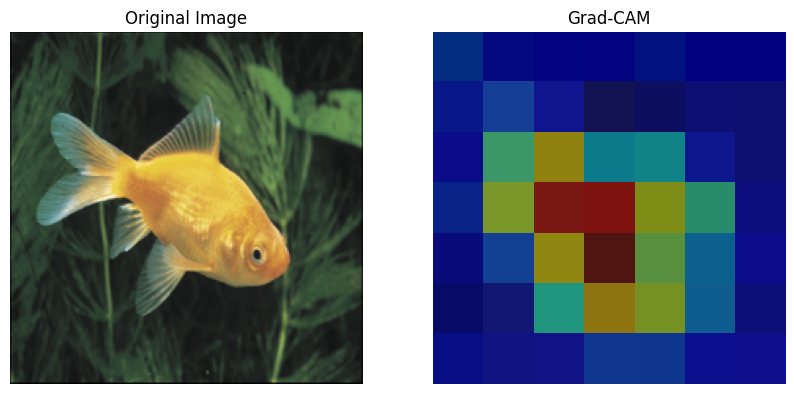

Predicted class index: 1
Layer index index: 2


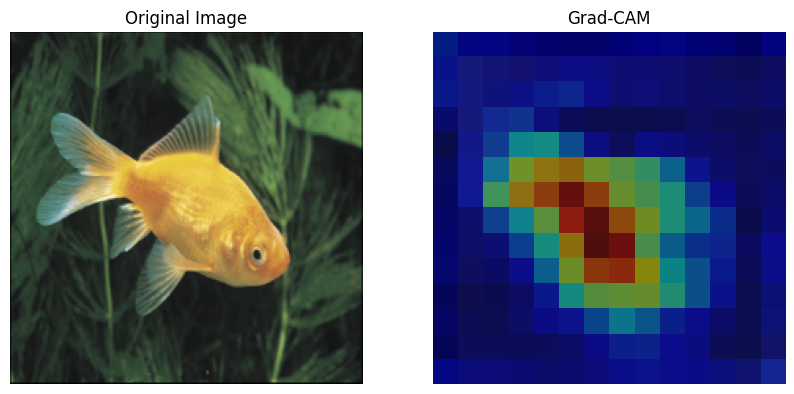

Predicted class index: 1
Layer index index: 3


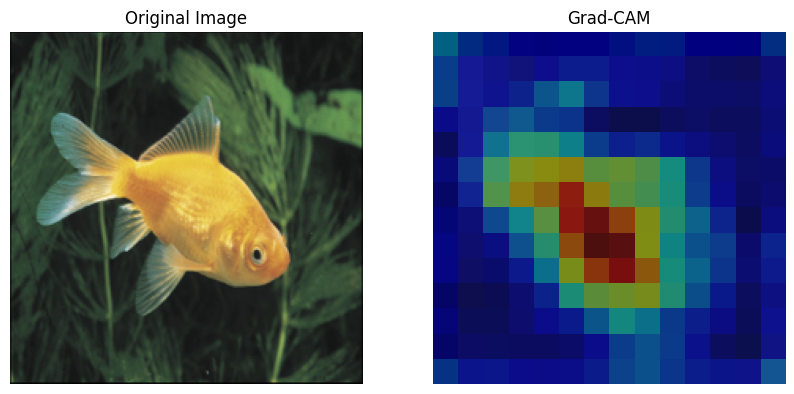

Predicted class index: 1
Layer index index: 4


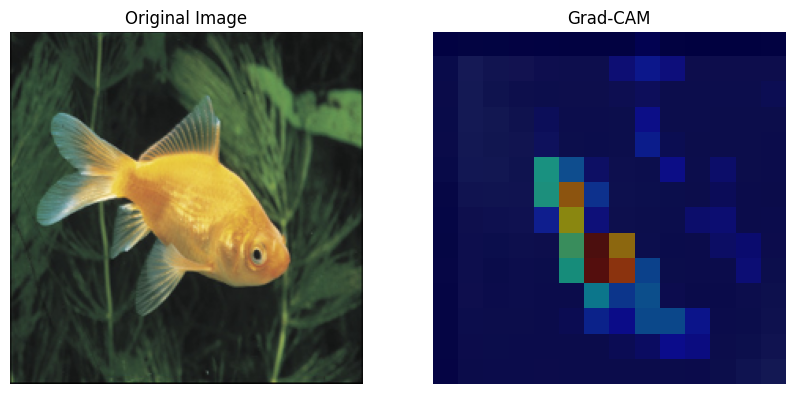

Predicted class index: 1
Layer index index: 5


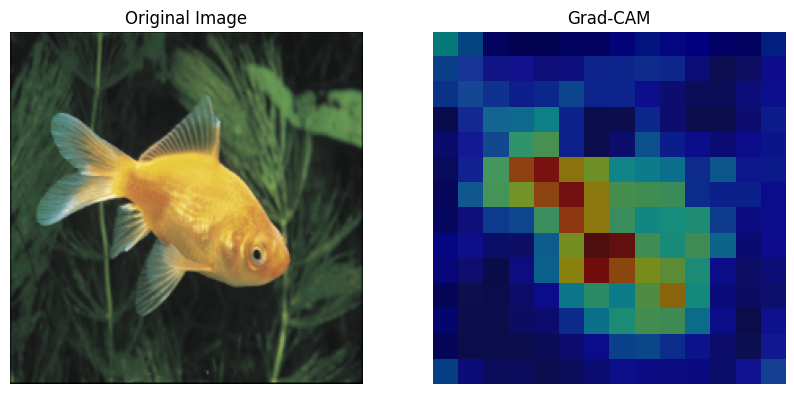

Predicted class index: 1
Layer index index: 6


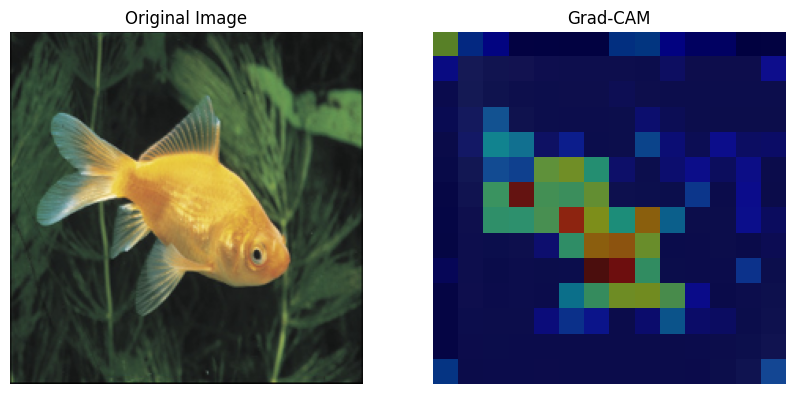

Predicted class index: 1
Layer index index: 7


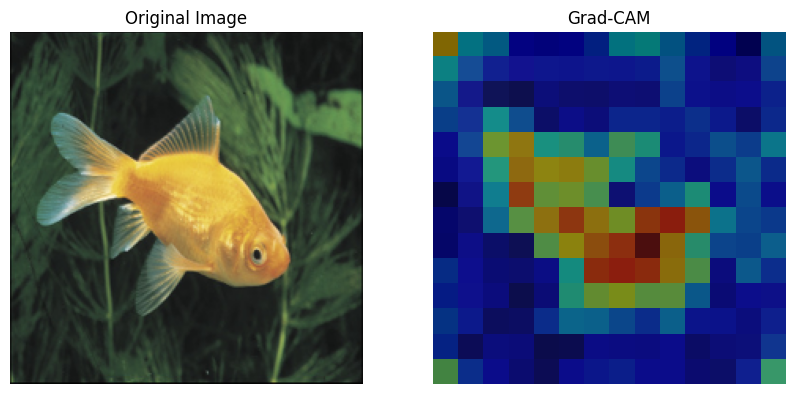

Predicted class index: 1
Layer index index: 8


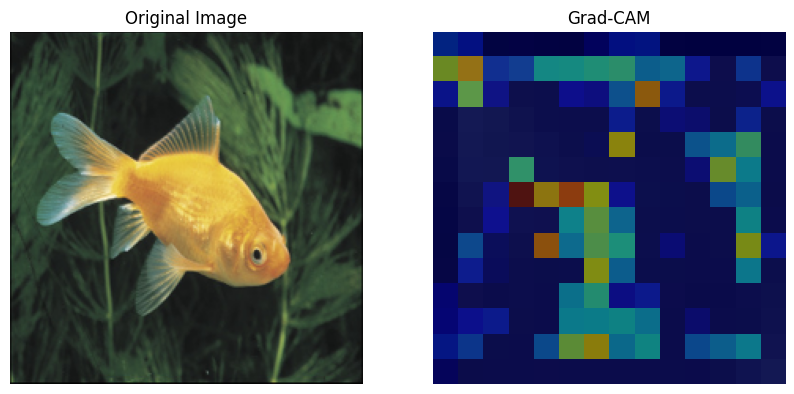

Predicted class index: 1
Layer index index: 9


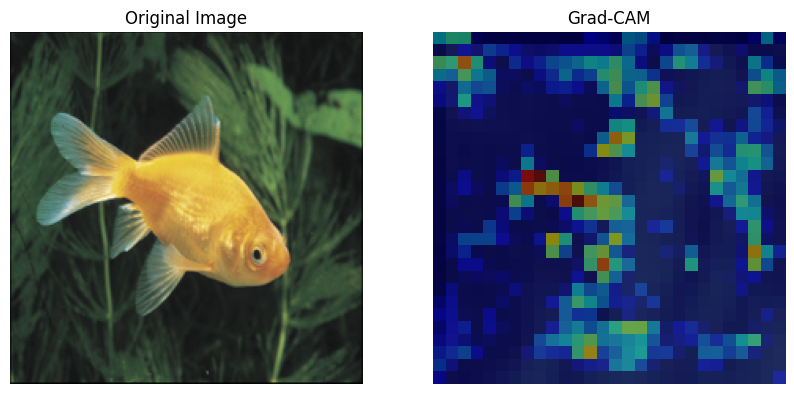

Predicted class index: 1
Layer index index: 10


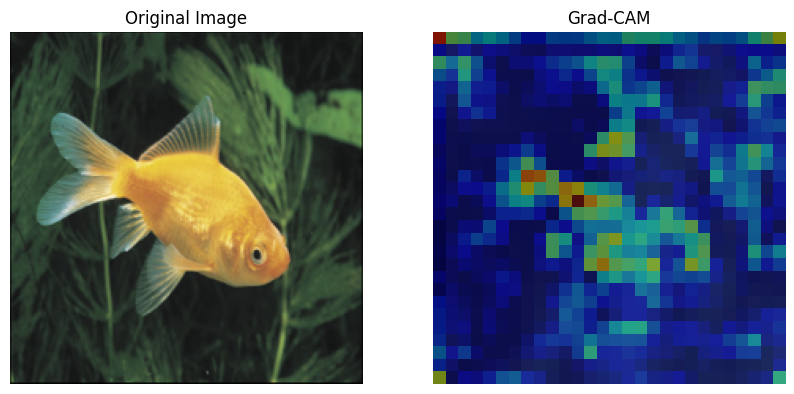

Predicted class index: 1
Layer index index: 11


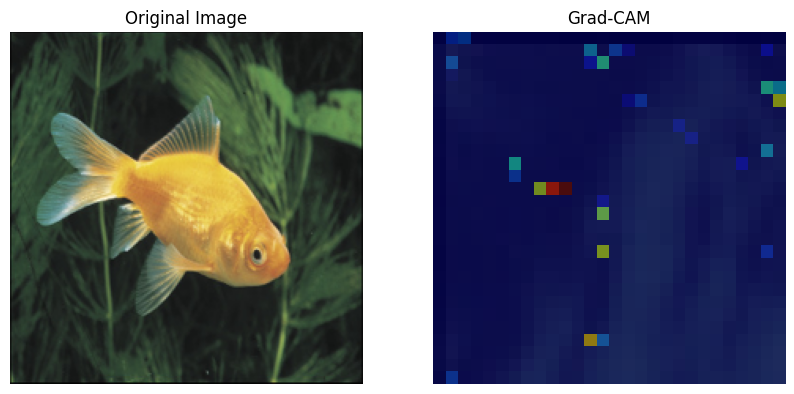

Predicted class index: 1
Layer index index: 12


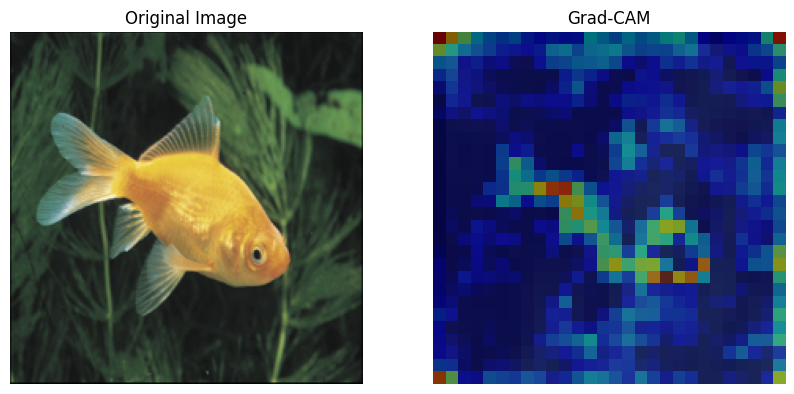

Predicted class index: 1
Layer index index: 13


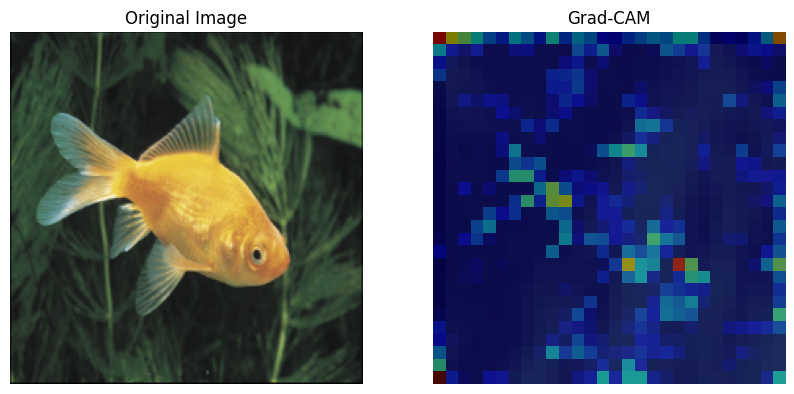

Predicted class index: 1
Layer index index: 14


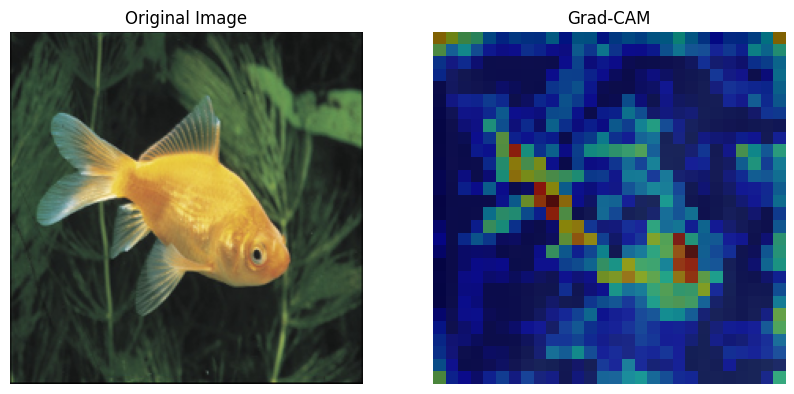

Predicted class index: 1
Layer index index: 15


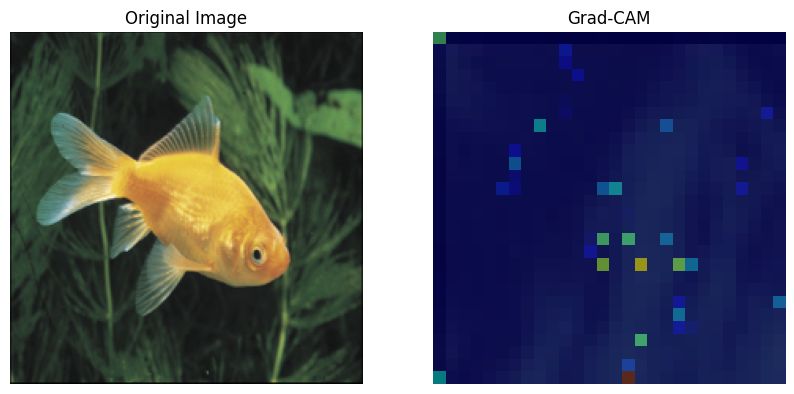

Predicted class index: 1
Layer index index: 16


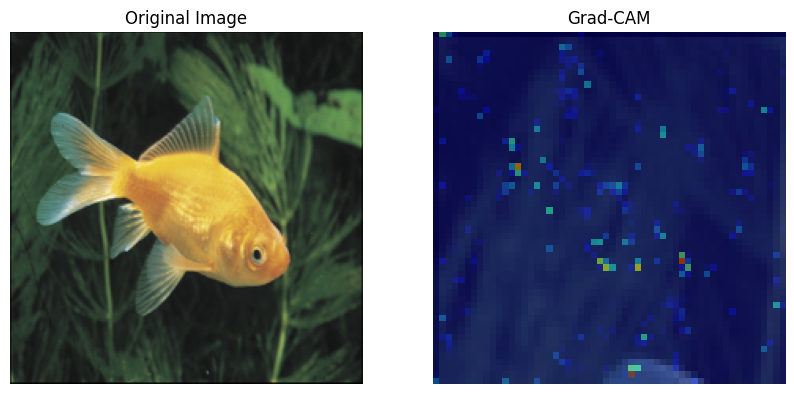

Predicted class index: 1
Layer index index: 17


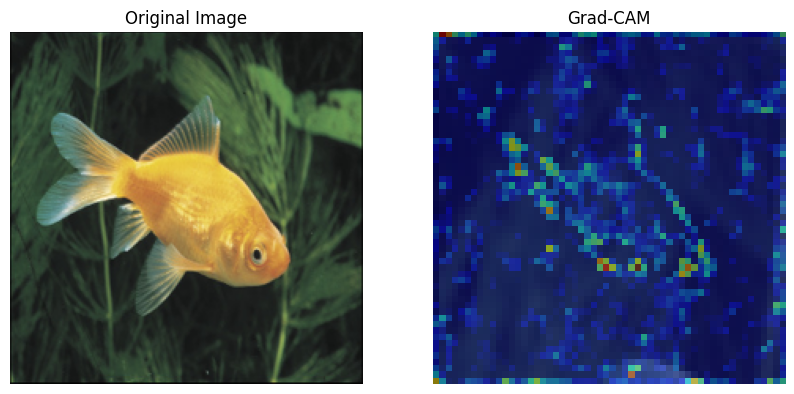

Predicted class index: 1
Layer index index: 18


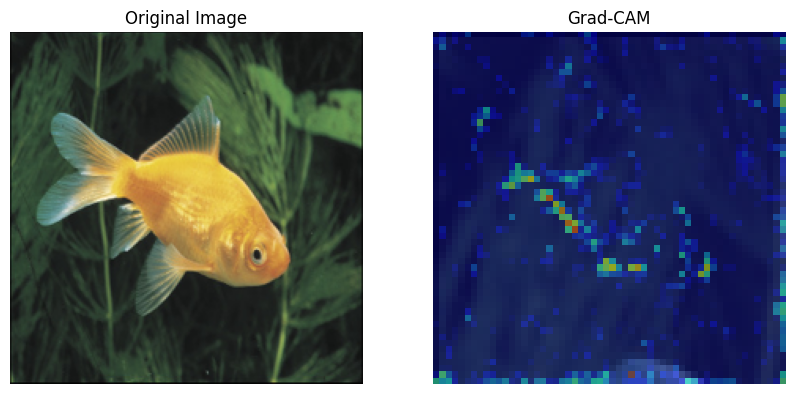

Predicted class index: 1
Layer index index: 19


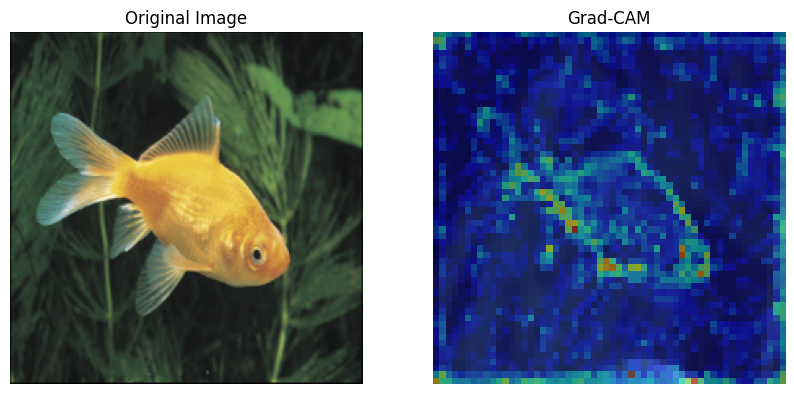

Predicted class index: 1
Layer index index: 20


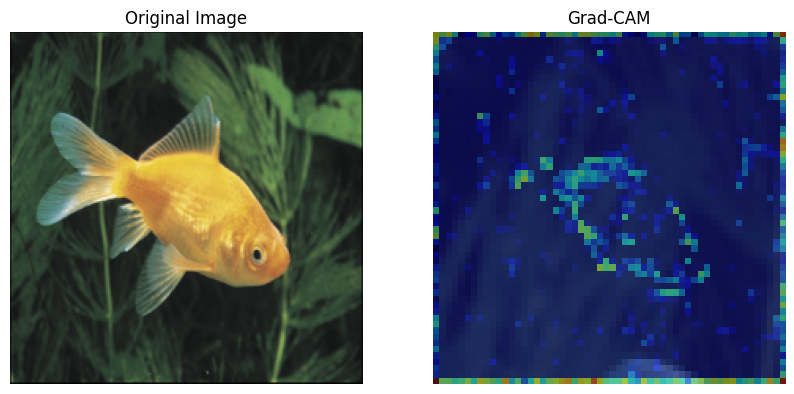

Predicted class index: 1
Layer index index: 21


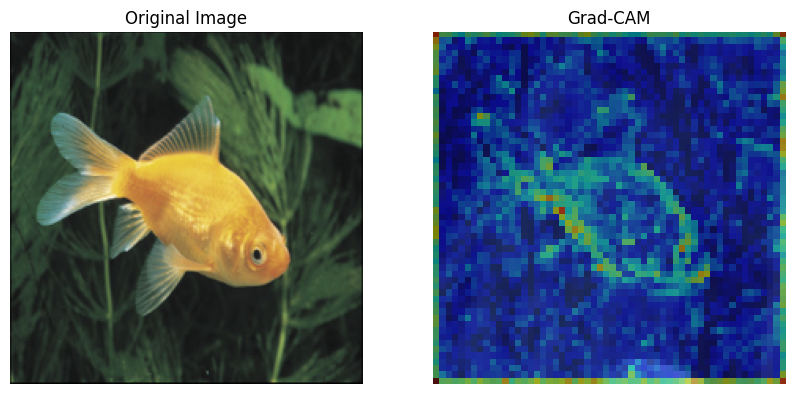

Predicted class index: 1
Layer index index: 22


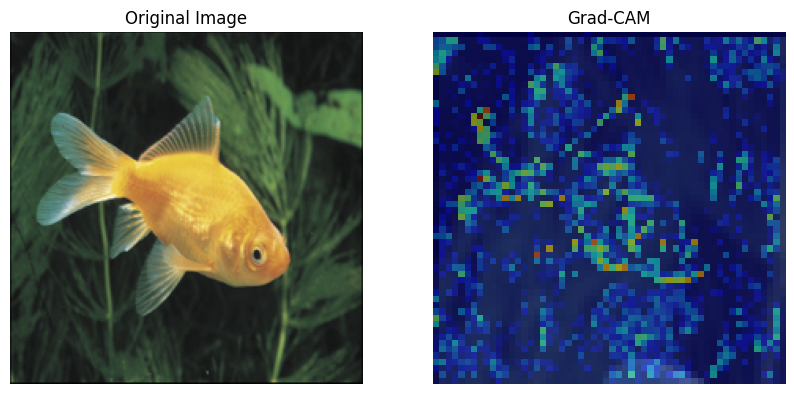

Predicted class index: 1
Layer index index: 23


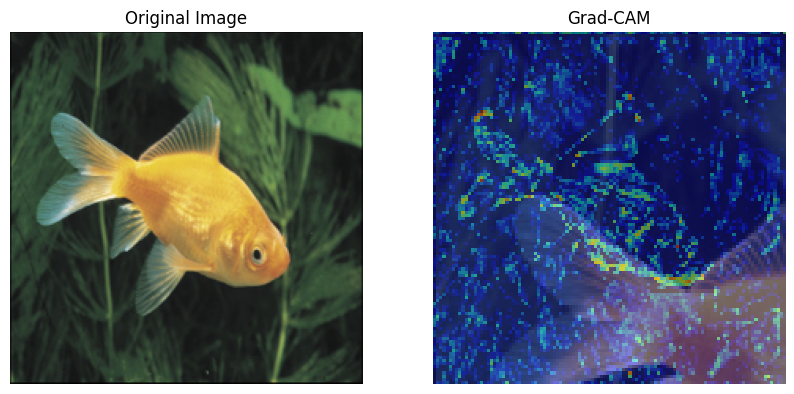

Predicted class index: 1
Layer index index: 24


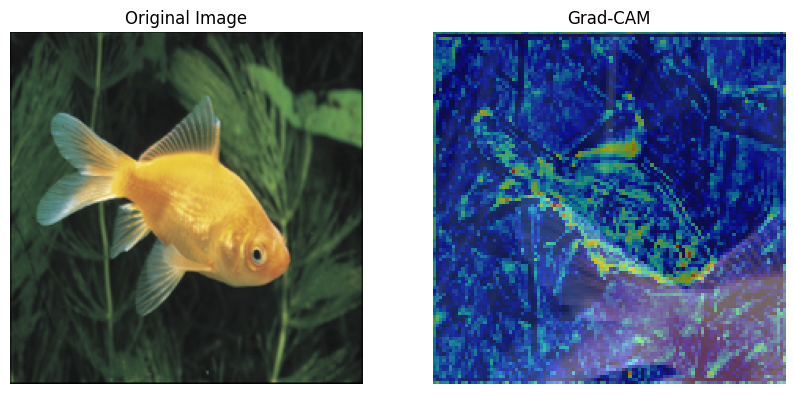

Predicted class index: 1
Layer index index: 25


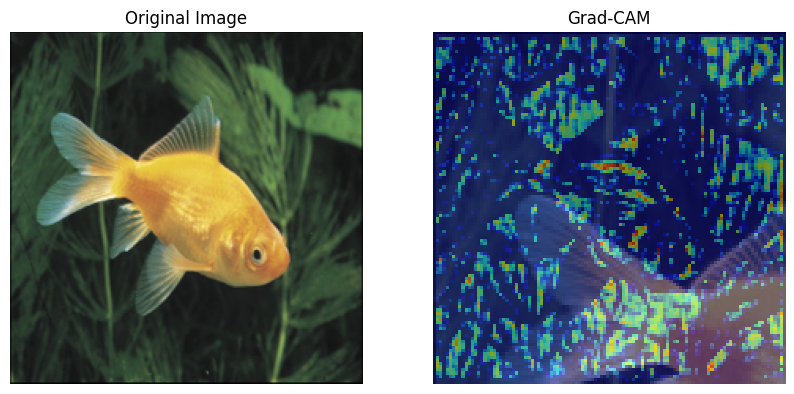

Predicted class index: 1
Layer index index: 26


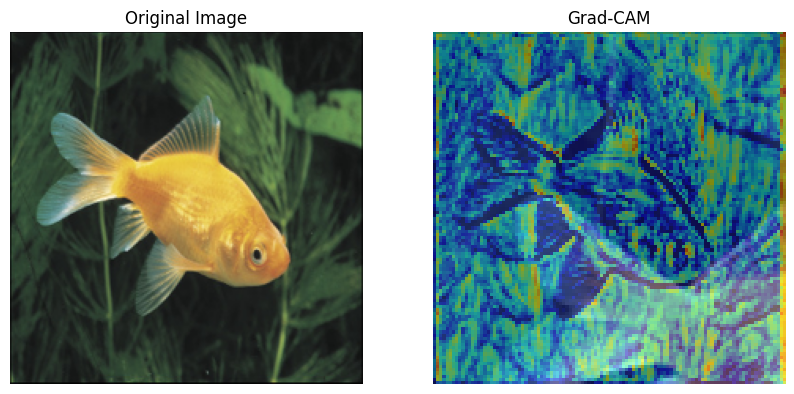

Predicted class index: 1
Layer index index: 27


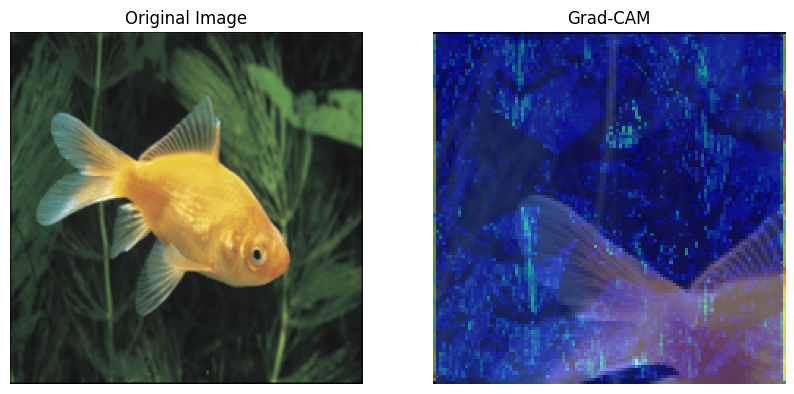

Predicted class index: 1
Layer index index: 28


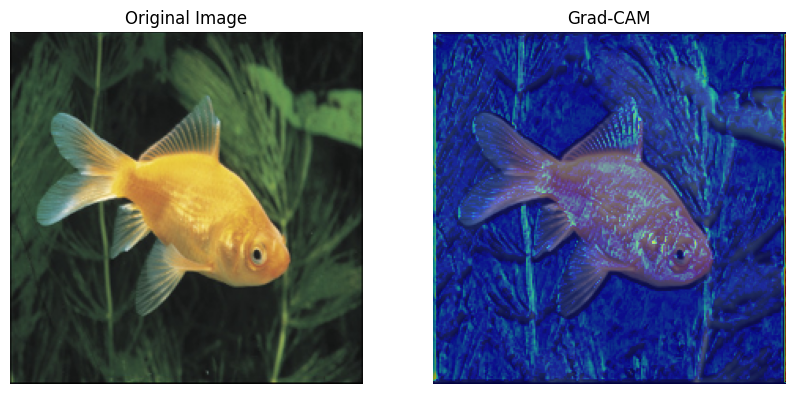

Predicted class index: 1
Layer index index: 29


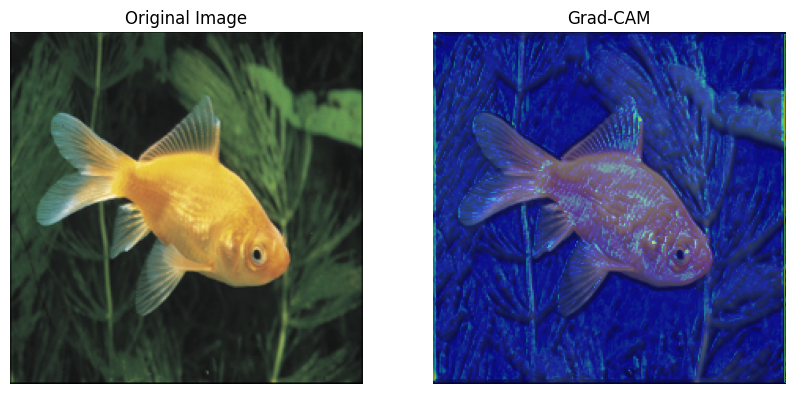

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import requests
import numpy as np

for layer_index in range(1,30):

    # 1. Load Pretrained VGG16
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # Set model to evaluation mode
    model.eval()

    # 2. Load and preprocess the image
    def preprocess_image(image_path):
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize((224, 224))
        img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
        return img_tensor, img_resized, img

    image_path = 'n01443537_goldfish.jpg'  # Replace with your image path
    img_tensor, img_resized, original_img = preprocess_image(image_path)

    # 3. Hook to get gradients and activations from the target layer
    gradients = None
    activations = None

    def save_gradients(grad):
        global gradients
        gradients = grad

    def hook_activations(module, input, output):
        global activations
        activations = output
        output.register_hook(save_gradients)

    # Attach hooks to the last convolutional layer
    target_layer = model.features[-layer_index]  # Last conv layer in VGG16
    target_layer.register_forward_hook(hook_activations)

    # 4. Forward pass through the model
    output = model(img_tensor)

    # 5. Get the index of the predicted class
    predicted_class = output.argmax().item()
    print(f'Predicted class index: {predicted_class}')

    print(f'Layer index index: {layer_index}')

    # 6. Backpropagate to compute gradients w.r.t. predicted class
    model.zero_grad()
    output[0, predicted_class].backward()

    # 7. Compute Grad-CAM
    def compute_gradcam(activations, gradients):
        # Global average pooling of the gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Weight the channels of activations by corresponding gradients
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Take the mean of the activations along the channel dimension and apply ReLU
        gradcam = torch.mean(activations, dim=1).squeeze()
        gradcam = np.maximum(gradcam.detach().numpy(), 0)  # ReLU

        # Normalize the Grad-CAM heatmap
        gradcam = gradcam - np.min(gradcam)
        gradcam = gradcam / np.max(gradcam)

        return gradcam

    # Generate Grad-CAM heatmap
    gradcam = compute_gradcam(activations, gradients)

    # 8. Visualize the Grad-CAM heatmap
    def show_gradcam(original_img, gradcam):
        plt.figure(figsize=(10, 5))

        # Display the original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.axis('off')
        plt.title('Original Image')

        # Display the Grad-CAM heatmap
        plt.subplot(1, 2, 2)
        plt.imshow(original_img)
        plt.imshow(gradcam, cmap='jet', alpha=0.5)  # Overlay Grad-CAM with transparency
        plt.axis('off')
        plt.title('Grad-CAM')

        plt.show()

    show_gradcam(img_resized, gradcam)
